# 解答例

## データの準備

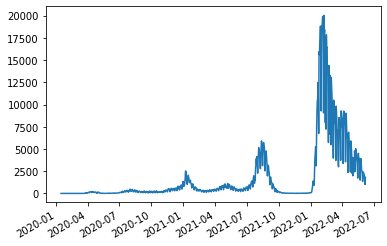

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

covid_data = pd.read_csv("https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv")
X = pd.to_datetime(covid_data["Date"])# datetime型に変換
Y = covid_data["Tokyo"].values
import matplotlib.dates as mdates
plt.plot(X,Y)
plt.gcf().autofmt_xdate() # 日付のフォーマットを整えてくれる
plt.show()

## データの前処理

**学習に用いる区間の決定**

ここでは直近35日を学習に用います．

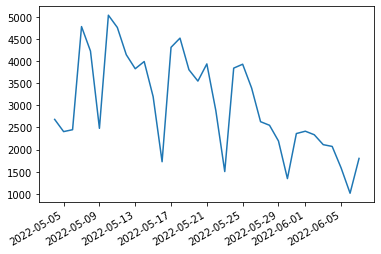

In [31]:
# 直近35日 (5週間) を用いる場合
x = X[-35:]
y = Y[-35:]
plt.plot(x,y)
plt.gcf().autofmt_xdate() # 日付のフォーマットを整えてくれる
plt.show()

**スケーリング**

今回は値の範囲が明確にはわからないため，**標準化**を用いてスケーリングします．

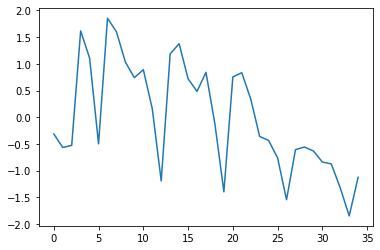

In [32]:
from sklearn.preprocessing import StandardScaler # 正規化のモジュール
ss = StandardScaler() # 正規化のクラスを準備
# スケーリング
y = y.reshape(-1, 1) # fit_transformに入力できるようにreshape
y = ss.fit_transform(y) # 正規化
plt.plot(y)

## パラメータの定義

あとで調整しやすいように，主要なパラメータをまとめて宣言しておきます．

In [33]:
train_test_split_rate = 0.8 # 何割をtrainにするか
time_step = 7 # 時系列データのステップ数．今回は一週間分見ます
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 300

## 訓練データの作成

In [34]:
train_size = int(len(y)*train_test_split_rate)
test_size = len(y) - train_size

train = y[0:train_size, :]
test = y[train_size:len(y), :]

print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 28, test size: 7 


In [35]:
n_sample = train_size-time_step-1  # サンプル数

input_data = np.zeros((n_sample, time_step, 1))  # 入力の空配列
correct_data = np.zeros((n_sample, 1))  # 正解の空配列

for i in range(n_sample):
    input_data[i] = y[i:i+time_step]
    correct_data[i] = y[i+time_step]  # 正解は入力よりも一つ後

PyTorchのDataLoaderで読み込みます．

In [36]:
import torch
from torch.utils.data import DataLoader

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)

dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)  # DataLoaderの設定

## モデルの構築

ここではGRUを用いてみます．

In [37]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(GRU, self).__init__()

        self.input_size = input_size # 入力データの次元
        self.hidden_dim = hidden_dim # 隠れ層の次元
        self.n_layers = n_layers # GRUを「上方向に」何層重ねるか？の設定 ※横方向ではない

        # GRUレイヤ．内部構造はすでに組まれている.
        # Dataloaderから取り出されるデータの仕様と合わせるためにbatch_first=True
        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size) # 隠れ状態 ➡ 出力の全結合層

    def forward(self, x):
        x = x.to(device)
        y_gru, h = self.gru(x, None) # 隠れ層の初期値を0とする場合Noneでよい．
        y = self.fc(y_gru[:, -1, :]) # 最後の時刻の出力だけを使用するので-1 (y_gru[batch, time_step, hidden_size])
        return y


In [39]:
#RNNの設定
n_inputs  = 1 # 入力は一次元
n_outputs = 1 # 出力も一次元
n_hidden  = 64 # 隠れ状態を64個に設定
n_layers  = 1 # 普通のRNN

model = GRU(n_inputs, n_outputs, n_hidden, n_layers).to(device) # GRUをインスタンス化
print(model) # 作成したRNNの層を簡易表示

GRU(
  (gru): GRU(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 学習

Epoch: 50 Loss_Train: 0.660246729850769


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


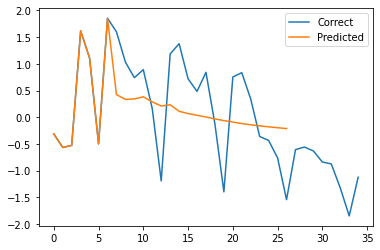

Epoch: 100 Loss_Train: 0.22110509872436523


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


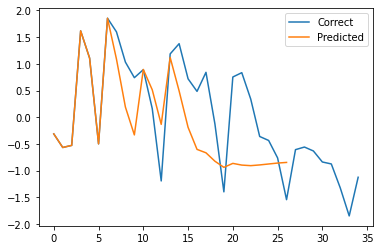

Epoch: 150 Loss_Train: 0.06468819081783295


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


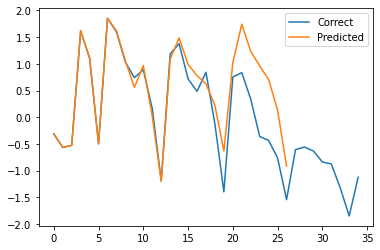

Epoch: 200 Loss_Train: 0.026900654658675194


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


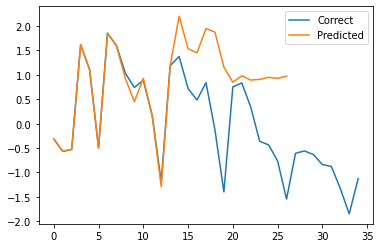

Epoch: 250 Loss_Train: 0.0112645598128438


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


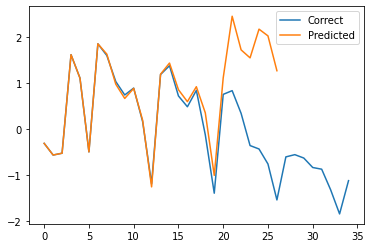

Epoch: 300 Loss_Train: 0.0044536585919559


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


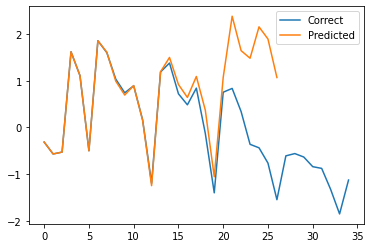

In [40]:
# MSE誤差関数
loss_fnc = nn.MSELoss()
# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # 学習率は0.001
# 損失のログ
record_loss_train = []
# 学習
for i in range(1, EPOCHS+1):
    model.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す．x: 入力，t: 真値
        pred_y = model(x)
        loss = loss_fnc(pred_y, t.to(device))
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%50 == 0: # 50 epochごとに予測の様子を可視化
        print("Epoch:", i, "Loss_Train:", loss_train)
        predicted = list(input_data[0]) # 最初 (t=0～9) の入力をリスト化
        model.eval()
        with torch.no_grad():
          for i in range(n_sample):
            x = torch.tensor(predicted[-time_step:])  # 直近の時系列を取り出す
            x = x.reshape(1, time_step, 1)  # (バッチサイズ, 時系列の数, 入力の数)
            pred_y = model(x)
            predicted.append(pred_y[0].item())  # 予測結果をpredictedに追加する
        plt.plot(range(len(y)), y, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()    

## 評価

損失関数の可視化

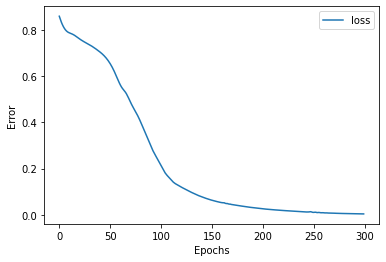

In [41]:
import matplotlib.pyplot as plt
plt.plot(range(len(record_loss_train)), record_loss_train, label="loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

未学習部分の予測

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


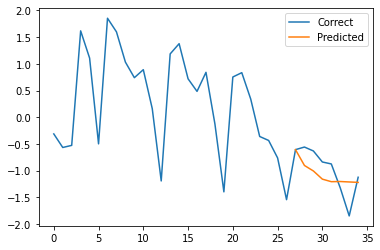

In [42]:
# 空のデータを作る
n_test_sample = test_size  # サンプル数
test_input_data = np.zeros((n_test_sample, time_step, 1))
correct_test_data = np.zeros((n_test_sample, 1))

# テストデータの入力と真値を作る
start_test = train_size-time_step
for i in range(n_test_sample):
    test_input_data[i] = y[start_test+i:start_test+i+time_step]
    correct_test_data[i] = y[start_test+i+time_step]

test_input_data = torch.tensor(test_input_data, dtype=torch.float)  # テンソルに変換
correct_test_data = torch.tensor(correct_test_data, dtype=torch.float)

#以下は学習時の評価と同じ
predicted = list(test_input_data[0]) # 最初の入力をリスト化

model.eval()
with torch.no_grad():
  for i in range(n_test_sample):
      x = torch.tensor(predicted[-time_step:])  # 直近の時系列を取り出す
      x = x.reshape(1, time_step, 1)  # (バッチサイズ, 時系列の数, 入力の数)
      pred_y = model(x)
      predicted.append(pred_y[0].item())  # 予測結果をpredictedに追加する
plt.plot(range(len(y)), y, label="Correct")
plt.plot(range(start_test+time_step-1, start_test+len(predicted)), predicted[time_step-1:] , label='Predicted') # x要素の範囲に注意
plt.legend()
plt.show()


標準化前のスケールに戻して描画

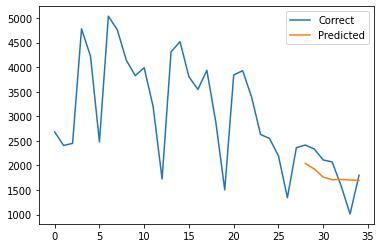

In [43]:
y_pred = ss.inverse_transform(np.array(predicted[time_step:]).reshape(-1, 1))
y_original = ss.inverse_transform(y)

plt.plot(range(len(y_original)), y_original, label="Correct")
plt.plot(range(start_test+time_step, start_test+len(predicted)), y_pred , label='Predicted')
plt.legend()
plt.show()

予測した時系列データと真値のMSEとRMSE

In [44]:
from sklearn.metrics import mean_squared_error

y_true = y_original[-test_size:] # yの後方test_size個分のデータ
mse = mean_squared_error(y_true, y_pred)
print("mse", mse)
rmse = np.sqrt(mse)
print("rmse", rmse)

mse 152057.38960565135
rmse 389.94536746274


## 未来の値を予測

In [45]:
train_test_split_rate = 1.0 # 何割をtrainにするか

In [46]:
train_size = int(len(y)*train_test_split_rate)
test_size = len(y) - train_size

train = y[0:train_size, :]
test = y[train_size:len(y), :]

print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 35, test size: 0 


In [47]:
n_sample = train_size-time_step-1  # サンプル数

input_data = np.zeros((n_sample, time_step, 1))  # 入力の空配列
correct_data = np.zeros((n_sample, 1))  # 正解の空配列

for i in range(n_sample):
    input_data[i] = y[i:i+time_step]
    correct_data[i] = y[i+time_step]  # 正解は入力よりも一つ後

In [48]:
import torch
from torch.utils.data import DataLoader

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)

dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)  # DataLoaderの設定

再度，モデルの作成，学習のし直しを行います．

In [49]:
model = GRU(n_inputs, n_outputs, n_hidden, n_layers).to(device) # GRUを再度インスタンス化
print(model) # 作成したRNNの層を簡易表示

GRU(
  (gru): GRU(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Epoch: 20 Loss_Train: 0.7040264010429382


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


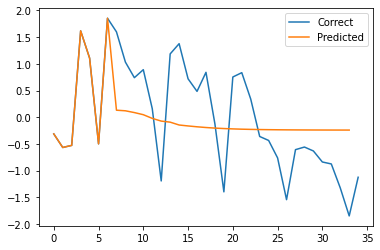

Epoch: 40 Loss_Train: 0.5315800309181213


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


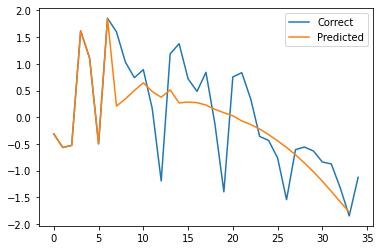

Epoch: 60 Loss_Train: 0.4827266037464142


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


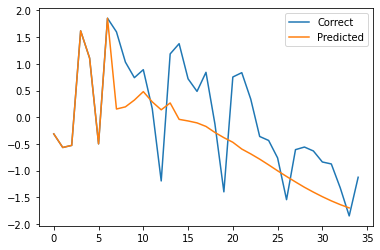

Epoch: 80 Loss_Train: 0.429989218711853


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


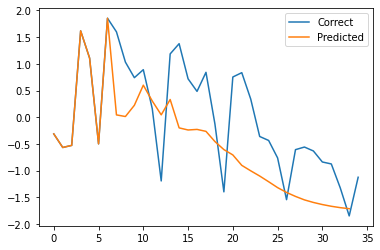

Epoch: 100 Loss_Train: 0.3581681549549103


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


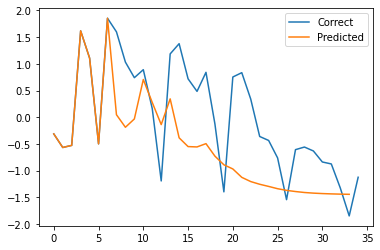

Epoch: 120 Loss_Train: 0.25863224267959595


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


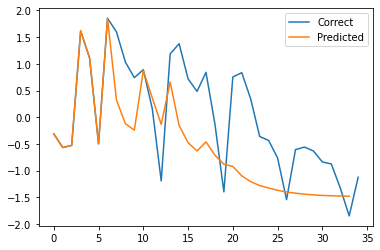

Epoch: 140 Loss_Train: 0.170249804854393


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


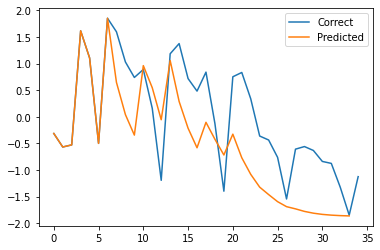

Epoch: 160 Loss_Train: 0.11178142577409744


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


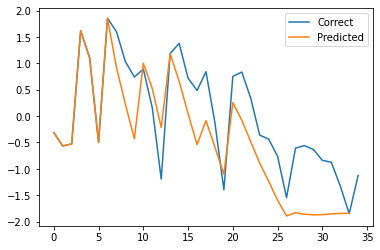

Epoch: 180 Loss_Train: 0.07638974487781525


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


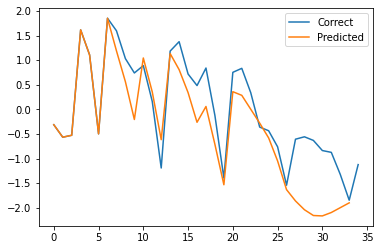

Epoch: 200 Loss_Train: 0.05660669133067131


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


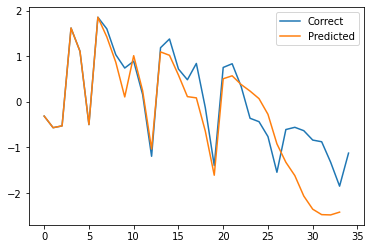

Epoch: 220 Loss_Train: 0.045303478837013245


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


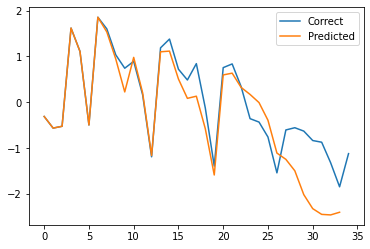

Epoch: 240 Loss_Train: 0.037252601236104965


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


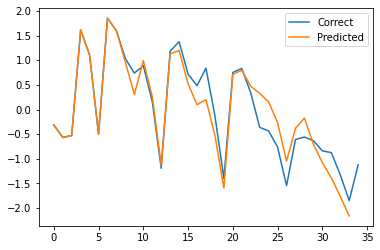

Epoch: 260 Loss_Train: 0.029312582686543465


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


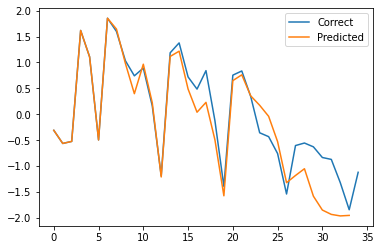

Epoch: 280 Loss_Train: 0.022624898701906204


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


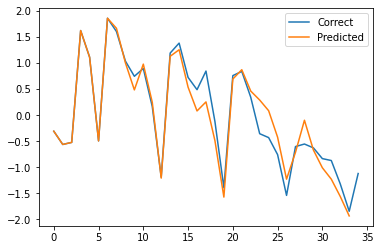

Epoch: 300 Loss_Train: 0.017977038398385048


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


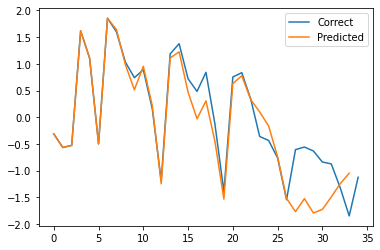

In [50]:
# MSE誤差関数
loss_fnc = nn.MSELoss()
# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # 学習率は0.001
# 損失のログ
record_loss_train = []
# 学習
for i in range(1, EPOCHS+1):
    model.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す．x: 入力，t: 真値
        pred_y = model(x)
        loss = loss_fnc(pred_y, t.to(device))
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%20 == 0: # 20 epochごとに予測の様子を可視化
        print("Epoch:", i, "Loss_Train:", loss_train)
        predicted = list(input_data[0]) # 最初 (t=0～9) の入力をリスト化
        model.eval()
        with torch.no_grad():
          for i in range(n_sample):
            x = torch.tensor(predicted[-time_step:])  # 直近の時系列を取り出す
            x = x.reshape(1, time_step, 1)  # (バッチサイズ, 時系列の数, 入力の数)
            pred_y = model(x)
            predicted.append(pred_y[0].item())  # 予測結果をpredictedに追加する
        plt.plot(range(len(y)), y, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()    

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


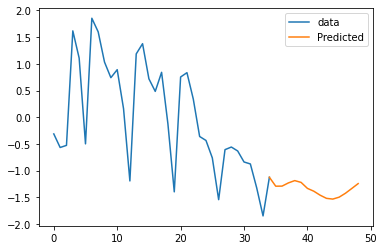

In [54]:
# 未来予測するステップ数
future_step = 14

# 真値との比較による評価は行わないため，テストデータは作らない

# 末尾time_step分の要素を最初の入力とする
input_data = torch.tensor(y[-time_step:], dtype=torch.float)  # テンソルに変換
predicted = list(input_data) # 末尾time_step分の要素を最初の入力とする

model.eval()
with torch.no_grad():
  for i in range(future_step):
      x = torch.tensor(predicted[-time_step:])  # 直近の時系列を取り出す
      x = x.reshape(1, time_step, 1)  # (バッチサイズ, 時系列の数, 入力の数)
      pred_y = model(x)
      predicted.append(pred_y[0].item())  # 予測結果をpredictedに追加する

# 標準化された状態での結果
plt.plot(range(len(y)), y, label="data")
plt.plot(range(len(y)-1, len(y)+future_step), predicted[time_step-1:] , label='Predicted') # dataの最後の点と最初の予測値を線分で結ぶため，predicted[time_step-1:]からplotを開始
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  


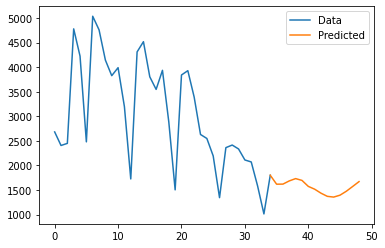

In [55]:
# 標準化をもとに戻す
y_pred = ss.inverse_transform(np.array(predicted[time_step-1:]).reshape(-1, 1))
y_original = ss.inverse_transform(y)

plt.plot(range(len(y_original)), y_original, label="Data")
plt.plot(range(len(y_original)-1, len(y_original)+future_step), y_pred, label='Predicted')
plt.legend()
plt.show()

In [53]:
print("二週間後の感染者数:",  y_pred[-1])

二週間後の感染者数: [1670.6837464]
